In [69]:
import glob
import pandas as pd
import numpy as np
import os
%matplotlib inline

import matplotlib.style as style
style.use(["seaborn-whitegrid", "seaborn-paper"])

### Experiment settings


8 GPUs total
30 jobs
1800 seconds(30 minutes)

We compare HyperSched vs ASHA. 

The truncation parameter for both is "wall-clock time". Each trial is given a minimum 60 seconds to execute, which ends up being about 3 epochs for ResNet50 on CIFAR10.

## Accuracy over time

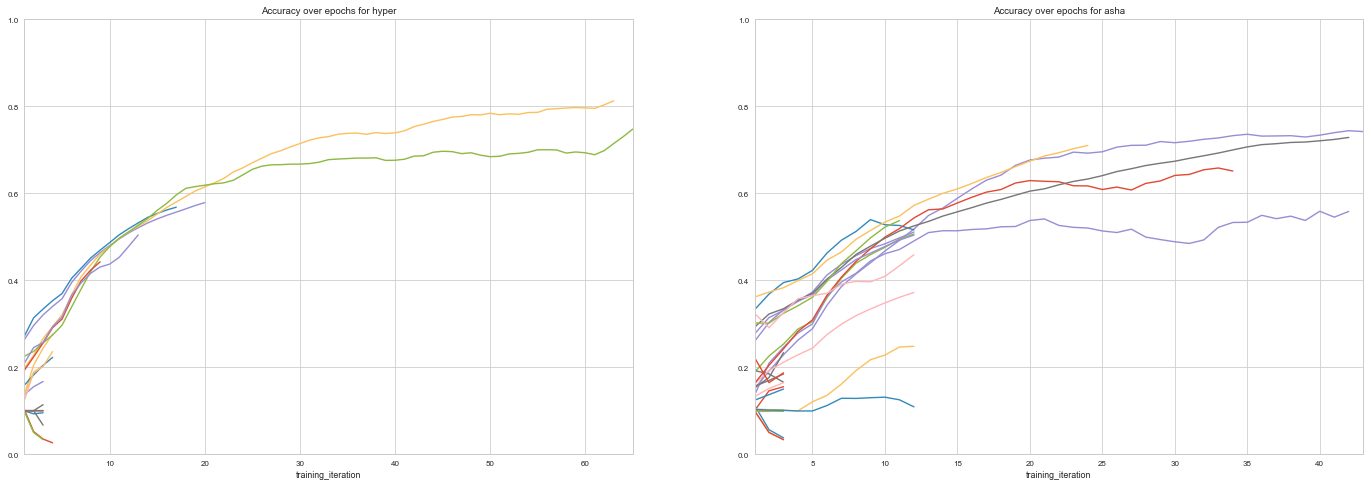

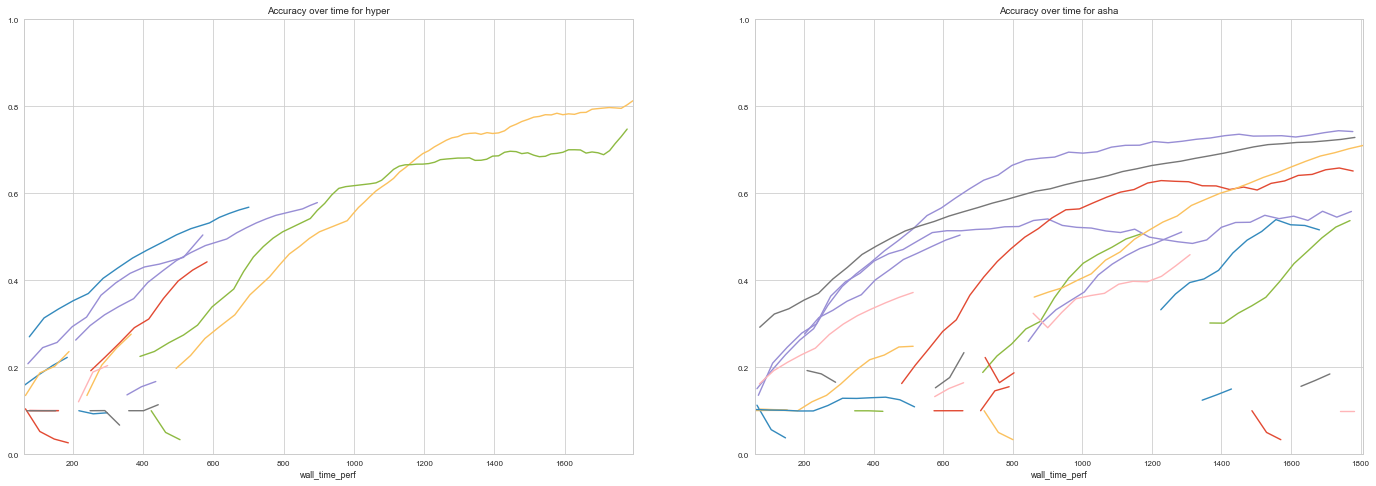

In [73]:
def plot_accuracy(list_of_schedules, schedule_names, metric):
    fig, ax_list = plt.subplots(1, len(list_of_schedules))
    
    for ax, schedule_df_list, schedule_name in zip(ax_list, list_of_schedules, schedule_names):
        for df in schedule_df_list:
            df.plot(metric, "mean_accuracy", ax=ax, legend=False)
    
        ax.set_ylim([0, 1])
    return fig, ax_list
    
schedules = ["hyper",  "asha"]
fig, ax_list = plot_accuracy([df_list_hyper, df_list_asha], schedules, "training_iteration") 
[ax.set_title(f"Accuracy over epochs for {schedule_name}") for ax, schedule_name in zip(ax_list, schedules)]
fig.set_size_inches(24, 8)

fig, ax_list = plot_accuracy([df_list_hyper, df_list_asha], schedules, "wall_time_perf") 
[ax.set_title(f"Accuracy over time for {schedule_name}") for ax, schedule_name in zip(ax_list, schedules)]
fig.set_size_inches(24, 8)

## Cumulative Max Accuracy

We see that HyperSched is able to obtain a significantly higher accuracy for the trained model given a deadline.

Text(0.5, 1.0, 'Max Accuracy vs Wallclock')

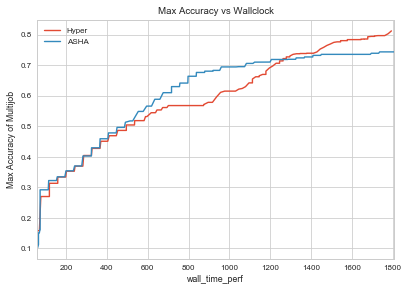

In [72]:
def get_dataframes(data_dir):
    hyper_csvs = glob.glob(os.path.join(data_dir, "**/progress.csv"), recursive=True)
    hyper_dfs = [pd.read_csv(x) for x in hyper_csvs if os.path.getsize(x) > 0]
    start = min([hdf.timestamp[0] - hdf.time_this_iter_s[0] - hdf.setup_time[0]  for hdf in hyper_dfs]) 
    
    for hdf in hyper_dfs:
        hdf["wall_time_perf"] = hdf.timestamp - start
    return hyper_dfs

def get_walltime_cummax_df(hyper_dfs):
    concatenated = pd.concat([hdf[["wall_time_perf", "mean_accuracy"]] for hdf in hyper_dfs])
    return concatenated.sort_values("wall_time_perf").cummax()

df_list_hyper = get_dataframes("./hyper-30-1800")
hyper = get_walltime_cummax_df(df_list_hyper)
ax = hyper.plot("wall_time_perf", "mean_accuracy", label="Hyper")

df_list_asha = get_dataframes("./asha-30-1800")
asha = get_walltime_cummax_df(df_list_asha)
asha.plot("wall_time_perf", "mean_accuracy", label="ASHA", ax=ax)
ax.set_ylabel("Max Accuracy of Multijob")
ax.set_title("Max Accuracy vs Wallclock")
# ax.figure.set_figsize_inc
# ax.figure.savefig("./max-accuracy-30j-1800.pdf")

### Resource Allocation

Resource allocation for both jobs is given below. 

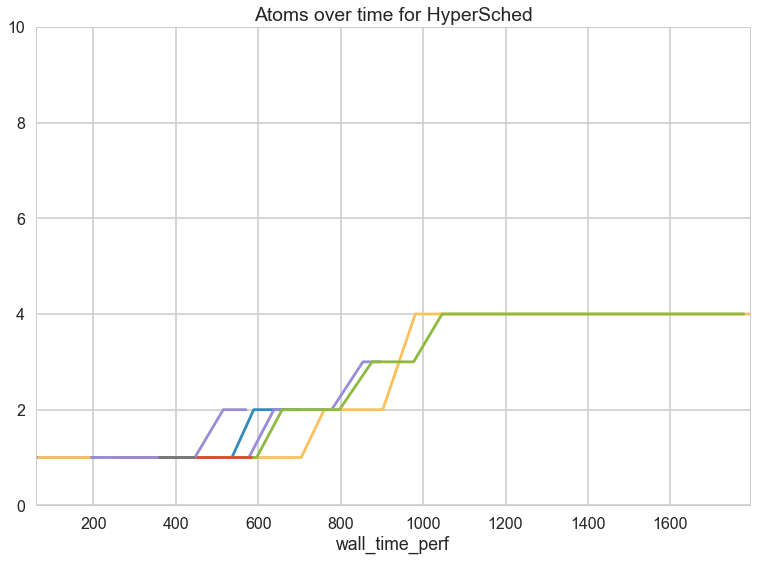

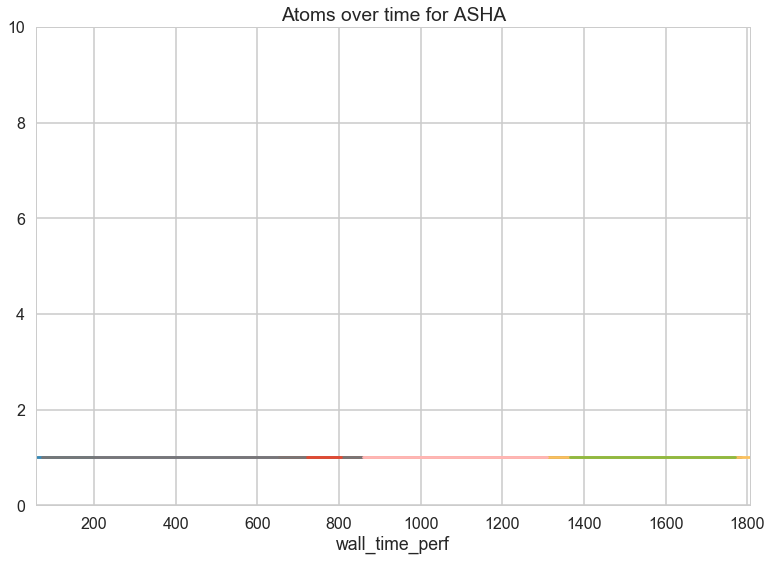

In [57]:
def plot_atoms(df_list, title):
    ax = None
    for df in df_list:
        ax = df.plot("wall_time_perf", "atoms", ax=ax, legend=False)
    
    ax.set_ylim([0, 10])
    ax.set_title(title)

plot_atoms(df_list_hyper, "Atoms over time for HyperSched")
plot_atoms(df_list_asha, "Atoms over time for ASHA")

In [67]:
[df["wall_time_perf"].to_list() for df in df_list_hyper], [df["atoms"].to_list() for df in df_list_hyper]

([[65.14458322525024,
   106.14458322525024,
   147.14458322525024,
   187.14458322525024],
  [217.14458322525024, 258.14458322525024, 298.14458322525024],
  [354.14458322525024, 395.14458322525024, 436.14458322525024],
  [249.14458322525024, 291.14458322525024, 333.14458322525024],
  [240.14458322525024,
   282.14458322525024,
   324.14458322525024,
   366.14458322525024],
  [423.14458322525024, 464.14458322525024, 505.14458322525024],
  [77.14458322525024, 118.14458322525024, 159.14458322525024],
  [77.14458322525024, 118.14458322525024, 159.14458322525024],
  [76.14458322525024,
   118.14458322525024,
   159.14458322525024,
   201.14458322525024,
   244.14458322525024,
   286.14458322525024,
   327.14458322525024,
   370.14458322525024,
   411.14458322525024,
   453.14458322525024,
   495.14458322525024,
   536.1445832252502,
   589.1445832252502,
   617.1445832252502,
   645.1445832252502,
   673.1445832252502,
   701.1445832252502],
  [208.14458322525024,
   249.14458322525024,
  